# 3辐照度预测———训练模型搭建

In [1]:
import os
import time
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot_ng as pydot
import math
import tensorflow as tf
import keras
import catboost as cb
from pandas import read_csv
from math import sqrt
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM,Flatten,Conv1D,MaxPooling1D,SimpleRNN,GRU
from keras.utils import np_utils,plot_model
from keras.models import model_from_json
# from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import svm
from keras.layers.core import Dense, Activation, Dropout
from sklearn.externals import joblib
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement = True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
config.gpu_options.allow_growth = True
sess0 = tf.InteractiveSession(config = config)

In [3]:
print(os.getcwd()) # 打印当前工作目录

E:\Research Project\DKA-WeatherStation


In [4]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 '101-Site_DKA-WeatherStation.csv',
 '1辐照度预测——数据提取重组融合.ipynb',
 '2009-2018暂存辐照度.csv',
 '2009-2018辐照度.csv',
 '2009-2018辐照度（每15min）.csv',
 '2009-2018辐照度（每15min）d+(d+1).csv',
 '2009按天辐照度.csv',
 '2010按天辐照度.csv',
 '2011辐照度.csv',
 '2011辐照度（每15min）.csv',
 '2011辐照度（每15min）d+(d+1).csv',
 '2辐照度预测———异常值空缺值融合构建训练集测试集.ipynb',
 '3辐照度预测———训练模型搭建.ipynb',
 '4辐照度预测———LSTM 结构模型.ipynb',
 'aaa.py',
 'CNN101.h5',
 'CNNLSTM106.h5',
 'DNN101.h5',
 'H5',
 'kpi',
 'LSTM102.h5',
 'model.png',
 'model.svg',
 'picture']

In [5]:
readdata = pd.read_csv('2009-2018辐照度（每15min）d+(d+1).csv')

In [6]:
readdata.head(3)

,Timestamp(d),Year(d),Month(d),Day(d),7:0.(d),7:15.(d),7:30.(d),7:45.(d),8:0.(d),8:15.(d),...,17:30.(d+1),17:45.(d+1),18:0.(d+1),18:15.(d+1),18:30.(d+1),18:45.(d+1),19:0.(d+1),19:15.(d+1),19:30.(d+1),19:45.(d+1)
0,2009/1/1,2009,1,1,69.547572,172.525439,346.184418,431.466736,399.969879,286.426025,...,370.609670,309.659342,247.962784,186.269068,128.375224,76.873255,34.446934,13.963012,6.609656,4.661077
1,2009/1/2,2009,1,2,217.125041,286.694814,348.620951,406.212087,464.882568,526.545258,...,396.843872,342.717072,263.926905,195.593023,132.444580,77.939009,44.119278,19.040752,6.297939,3.578515
2,2009/1/3,2009,1,3,198.361186,268.127340,336.591858,395.856018,456.667145,519.893545,...,375.296550,229.727109,251.156123,214.154139,161.210236,57.794492,28.367191,11.132816,5.073857,2.746905


In [7]:
readdata.shape

(3535, 108)

In [8]:
print(list(readdata))

['Timestamp(d)', 'Year(d)', 'Month(d)', 'Day(d)', '7:0.(d)', '7:15.(d)', '7:30.(d)', '7:45.(d)', '8:0.(d)', '8:15.(d)', '8:30.(d)', '8:45.(d)', '9:0.(d)', '9:15.(d)', '9:30.(d)', '9:45.(d)', '10:0.(d)', '10:15.(d)', '10:30.(d)', '10:45.(d)', '11:0.(d)', '11:15.(d)', '11:30.(d)', '11:45.(d)', '12:0.(d)', '12:15.(d)', '12:30.(d)', '12:45.(d)', '13:0.(d)', '13:15.(d)', '13:30.(d)', '13:45.(d)', '14:0.(d)', '14:15.(d)', '14:30.(d)', '14:45.(d)', '15:0.(d)', '15:15.(d)', '15:30.(d)', '15:45.(d)', '16:0.(d)', '16:15.(d)', '16:30.(d)', '16:45.(d)', '17:0.(d)', '17:15.(d)', '17:30.(d)', '17:45.(d)', '18:0.(d)', '18:15.(d)', '18:30.(d)', '18:45.(d)', '19:0.(d)', '19:15.(d)', '19:30.(d)', '19:45.(d)', '7:0.(d+1)', '7:15.(d+1)', '7:30.(d+1)', '7:45.(d+1)', '8:0.(d+1)', '8:15.(d+1)', '8:30.(d+1)', '8:45.(d+1)', '9:0.(d+1)', '9:15.(d+1)', '9:30.(d+1)', '9:45.(d+1)', '10:0.(d+1)', '10:15.(d+1)', '10:30.(d+1)', '10:45.(d+1)', '11:0.(d+1)', '11:15.(d+1)', '11:30.(d+1)', '11:45.(d+1)', '12:0.(d+1)', '1

In [9]:
# data2016=readdata.loc[readdata['Year(d)']==2016].copy()
data2016=readdata.copy()

In [10]:
data2016.head

<bound method NDFrame.head of      Timestamp(d)  Year(d)  Month(d)  Day(d)     7:0.(d)    7:15.(d)  \
0        2009/1/1     2009         1       1   69.547572  172.525439   
1        2009/1/2     2009         1       2  217.125041  286.694814   
2        2009/1/3     2009         1       3  198.361186  268.127340   
3        2009/1/4     2009         1       4  197.530614  263.462957   
4        2009/1/5     2009         1       5  192.138123  258.078491   
5        2009/1/6     2009         1       6  190.245458  255.405726   
6        2009/1/7     2009         1       7  190.891327  252.880096   
7        2009/1/8     2009         1       8  105.413287  167.696205   
8        2009/1/9     2009         1       9  155.561157  216.828557   
9       2009/1/10     2009         1      10  181.363439  248.468155   
10      2009/1/11     2009         1      11  191.673426  261.160055   
11      2009/1/12     2009         1      12  194.391897  263.926071   
12      2009/1/13     2009        

# keras模型训练

In [11]:
print(list(data2016))

['Timestamp(d)', 'Year(d)', 'Month(d)', 'Day(d)', '7:0.(d)', '7:15.(d)', '7:30.(d)', '7:45.(d)', '8:0.(d)', '8:15.(d)', '8:30.(d)', '8:45.(d)', '9:0.(d)', '9:15.(d)', '9:30.(d)', '9:45.(d)', '10:0.(d)', '10:15.(d)', '10:30.(d)', '10:45.(d)', '11:0.(d)', '11:15.(d)', '11:30.(d)', '11:45.(d)', '12:0.(d)', '12:15.(d)', '12:30.(d)', '12:45.(d)', '13:0.(d)', '13:15.(d)', '13:30.(d)', '13:45.(d)', '14:0.(d)', '14:15.(d)', '14:30.(d)', '14:45.(d)', '15:0.(d)', '15:15.(d)', '15:30.(d)', '15:45.(d)', '16:0.(d)', '16:15.(d)', '16:30.(d)', '16:45.(d)', '17:0.(d)', '17:15.(d)', '17:30.(d)', '17:45.(d)', '18:0.(d)', '18:15.(d)', '18:30.(d)', '18:45.(d)', '19:0.(d)', '19:15.(d)', '19:30.(d)', '19:45.(d)', '7:0.(d+1)', '7:15.(d+1)', '7:30.(d+1)', '7:45.(d+1)', '8:0.(d+1)', '8:15.(d+1)', '8:30.(d+1)', '8:45.(d+1)', '9:0.(d+1)', '9:15.(d+1)', '9:30.(d+1)', '9:45.(d+1)', '10:0.(d+1)', '10:15.(d+1)', '10:30.(d+1)', '10:45.(d+1)', '11:0.(d+1)', '11:15.(d+1)', '11:30.(d+1)', '11:45.(d+1)', '12:0.(d+1)', '1

In [12]:
data2016.drop(columns='Timestamp(d)')

,Year(d),Month(d),Day(d),7:0.(d),7:15.(d),7:30.(d),7:45.(d),8:0.(d),8:15.(d),8:30.(d),...,17:30.(d+1),17:45.(d+1),18:0.(d+1),18:15.(d+1),18:30.(d+1),18:45.(d+1),19:0.(d+1),19:15.(d+1),19:30.(d+1),19:45.(d+1)
0,2009,1,1,69.547572,172.525439,346.184418,431.466736,399.969879,286.426025,317.706991,...,370.609670,309.659342,247.962784,186.269068,128.375224,76.873255,34.446934,13.963012,6.609656,4.661077
1,2009,1,2,217.125041,286.694814,348.620951,406.212087,464.882568,526.545258,586.624146,...,396.843872,342.717072,263.926905,195.593023,132.444580,77.939009,44.119278,19.040752,6.297939,3.578515
2,2009,1,3,198.361186,268.127340,336.591858,395.856018,456.667145,519.893545,583.132365,...,375.296550,229.727109,251.156123,214.154139,161.210236,57.794492,28.367191,11.132816,5.073857,2.746905
3,2009,1,4,197.530614,263.462957,325.515991,381.755819,440.651398,498.782481,554.108846,...,145.663063,124.460625,89.832476,56.051145,30.281507,26.159934,14.963341,8.348274,5.085345,4.080695
4,2009,1,5,192.138123,258.078491,321.122915,378.862813,436.805511,498.423320,556.736471,...,265.356323,249.234929,182.835882,154.042969,198.114629,113.686554,52.938282,25.614613,7.622757,3.752770
5,2009,1,6,190.245458,255.405726,317.514587,373.904215,433.374898,488.775625,548.296855,...,91.731679,87.453443,110.178597,75.847331,51.487726,41.561773,33.699253,21.592031,5.642986,4.580985
6,2009,1,7,190.891327,252.880096,313.902059,369.186920,311.354390,290.014130,251.575343,...,374.711690,299.308528,215.966263,144.843908,104.836009,79.247098,36.090487,13.582575,5.886935,3.925524
7,2009,1,8,105.413287,167.696205,278.562195,300.617564,425.772105,419.340612,582.940104,...,364.297770,303.693654,242.815491,181.319366,123.433632,74.083536,36.869883,14.619606,6.568018,4.278584
8,2009,1,9,155.561157,216.828557,278.723094,340.870514,400.820363,466.674438,526.366506,...,378.057983,317.581116,257.372065,194.881231,134.933334,82.799632,41.159291,16.367856,6.824109,5.221718
9,2009,1,10,181.363439,248.468155,317.807119,375.967794,434.610118,499.531606,559.794535,...,384.761688,325.966166,263.072200,200.024226,139.220225,85.837463,42.217292,15.878043,7.443807,5.923368


In [13]:
data2016.head()

,Timestamp(d),Year(d),Month(d),Day(d),7:0.(d),7:15.(d),7:30.(d),7:45.(d),8:0.(d),8:15.(d),...,17:30.(d+1),17:45.(d+1),18:0.(d+1),18:15.(d+1),18:30.(d+1),18:45.(d+1),19:0.(d+1),19:15.(d+1),19:30.(d+1),19:45.(d+1)
0,2009/1/1,2009,1,1,69.547572,172.525439,346.184418,431.466736,399.969879,286.426025,...,370.609670,309.659342,247.962784,186.269068,128.375224,76.873255,34.446934,13.963012,6.609656,4.661077
1,2009/1/2,2009,1,2,217.125041,286.694814,348.620951,406.212087,464.882568,526.545258,...,396.843872,342.717072,263.926905,195.593023,132.444580,77.939009,44.119278,19.040752,6.297939,3.578515
2,2009/1/3,2009,1,3,198.361186,268.127340,336.591858,395.856018,456.667145,519.893545,...,375.296550,229.727109,251.156123,214.154139,161.210236,57.794492,28.367191,11.132816,5.073857,2.746905
3,2009/1/4,2009,1,4,197.530614,263.462957,325.515991,381.755819,440.651398,498.782481,...,145.663063,124.460625,89.832476,56.051145,30.281507,26.159934,14.963341,8.348274,5.085345,4.080695
4,2009/1/5,2009,1,5,192.138123,258.078491,321.122915,378.862813,436.805511,498.423320,...,265.356323,249.234929,182.835882,154.042969,198.114629,113.686554,52.938282,25.614613,7.622757,3.752770


# 归一化

In [14]:
train=data2016.drop(columns=['Timestamp(d)','Year(d)', 'Month(d)', 'Day(d)']).copy()

In [15]:
print(list(train))

['7:0.(d)', '7:15.(d)', '7:30.(d)', '7:45.(d)', '8:0.(d)', '8:15.(d)', '8:30.(d)', '8:45.(d)', '9:0.(d)', '9:15.(d)', '9:30.(d)', '9:45.(d)', '10:0.(d)', '10:15.(d)', '10:30.(d)', '10:45.(d)', '11:0.(d)', '11:15.(d)', '11:30.(d)', '11:45.(d)', '12:0.(d)', '12:15.(d)', '12:30.(d)', '12:45.(d)', '13:0.(d)', '13:15.(d)', '13:30.(d)', '13:45.(d)', '14:0.(d)', '14:15.(d)', '14:30.(d)', '14:45.(d)', '15:0.(d)', '15:15.(d)', '15:30.(d)', '15:45.(d)', '16:0.(d)', '16:15.(d)', '16:30.(d)', '16:45.(d)', '17:0.(d)', '17:15.(d)', '17:30.(d)', '17:45.(d)', '18:0.(d)', '18:15.(d)', '18:30.(d)', '18:45.(d)', '19:0.(d)', '19:15.(d)', '19:30.(d)', '19:45.(d)', '7:0.(d+1)', '7:15.(d+1)', '7:30.(d+1)', '7:45.(d+1)', '8:0.(d+1)', '8:15.(d+1)', '8:30.(d+1)', '8:45.(d+1)', '9:0.(d+1)', '9:15.(d+1)', '9:30.(d+1)', '9:45.(d+1)', '10:0.(d+1)', '10:15.(d+1)', '10:30.(d+1)', '10:45.(d+1)', '11:0.(d+1)', '11:15.(d+1)', '11:30.(d+1)', '11:45.(d+1)', '12:0.(d+1)', '12:15.(d+1)', '12:30.(d+1)', '12:45.(d+1)', '13:0.

In [16]:
print(list(train).index('7:0.(d)'))
print(list(train).index('7:0.(d+1)'))
print(list(train).index('19:45.(d+1)'))

0
52
103


In [17]:
(list(train).index('7:0.(d)'))

0

In [18]:
train1 = train.values
train1 = train1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
train1 = scaler.fit_transform(train1)

# test1 = test1.values
# test1 = test1.astype('float32')     # 将整型变为float
# scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
# test1 = scaler.fit_transform(test1)

inds = np.arange(train1.shape[0])
train1_inds = inds[0:int(train1.shape[0]*0.7)]
eval1_inds = inds[int(train1.shape[0]*0.7):train1.shape[0]]

In [19]:
print(list(train))

['7:0.(d)', '7:15.(d)', '7:30.(d)', '7:45.(d)', '8:0.(d)', '8:15.(d)', '8:30.(d)', '8:45.(d)', '9:0.(d)', '9:15.(d)', '9:30.(d)', '9:45.(d)', '10:0.(d)', '10:15.(d)', '10:30.(d)', '10:45.(d)', '11:0.(d)', '11:15.(d)', '11:30.(d)', '11:45.(d)', '12:0.(d)', '12:15.(d)', '12:30.(d)', '12:45.(d)', '13:0.(d)', '13:15.(d)', '13:30.(d)', '13:45.(d)', '14:0.(d)', '14:15.(d)', '14:30.(d)', '14:45.(d)', '15:0.(d)', '15:15.(d)', '15:30.(d)', '15:45.(d)', '16:0.(d)', '16:15.(d)', '16:30.(d)', '16:45.(d)', '17:0.(d)', '17:15.(d)', '17:30.(d)', '17:45.(d)', '18:0.(d)', '18:15.(d)', '18:30.(d)', '18:45.(d)', '19:0.(d)', '19:15.(d)', '19:30.(d)', '19:45.(d)', '7:0.(d+1)', '7:15.(d+1)', '7:30.(d+1)', '7:45.(d+1)', '8:0.(d+1)', '8:15.(d+1)', '8:30.(d+1)', '8:45.(d+1)', '9:0.(d+1)', '9:15.(d+1)', '9:30.(d+1)', '9:45.(d+1)', '10:0.(d+1)', '10:15.(d+1)', '10:30.(d+1)', '10:45.(d+1)', '11:0.(d+1)', '11:15.(d+1)', '11:30.(d+1)', '11:45.(d+1)', '12:0.(d+1)', '12:15.(d+1)', '12:30.(d+1)', '12:45.(d+1)', '13:0.

In [20]:
train_X, train_y = train1[train1_inds,(list(train).index('7:0.(d)')):(list(train).index('7:0.(d+1)'))], train1[train1_inds,(list(train).index('7:0.(d+1)')):]
eval_X,eval_y = train1[eval1_inds,(list(train).index('7:0.(d)')):(list(train).index('7:0.(d+1)'))], train1[eval1_inds,(list(train).index('7:0.(d+1)')):]
#reshape for CNN model
train_X_c = np.expand_dims(train_X, axis=2)#增加一维轴
eval_X_c = np.expand_dims(eval_X, axis=2)

#reshape input to be 3D [samples,timsteps,features]
train_X_l = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
eval_X_l = eval_X.reshape((eval_X.shape[0],1,eval_X.shape[1]))


In [21]:
print(train_X.shape, train_y.shape,eval_X.shape,eval_y.shape)
print(train_X_c.shape, train_y.shape,eval_X_c.shape,eval_y.shape)
print(train_X_l.shape, train_y.shape,eval_X_l.shape,eval_y.shape)

(2474, 52) (2474, 52) (1061, 52) (1061, 52)
(2474, 52, 1) (2474, 52) (1061, 52, 1) (1061, 52)
(2474, 1, 52) (2474, 52) (1061, 1, 52) (1061, 52)


In [22]:
train_X.shape[1]

52

# DNN模型

In [23]:

model=Sequential() #初始化模型
model.add(Dense(units=128, input_shape = (train_X.shape[1],),activation='tanh',name='Layer1',use_bias = True))
model.add(Dense(units=64,activation='tanh',name='Layer2',use_bias = True))
model.add(Dense(units=32,activation='tanh',name='Layer3',use_bias = True))
# model.add(Dense(units=32,activation='sigmoid',name='layer4',use_bias = True))
model.add(Dense(train_y.shape[1],activation='tanh',name='Output')) #添加输出层

plot_model(model,to_file="./picture/DNN_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
print(model.summary())

dnnstart = time.clock() #开始计时
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])  # 编译，指定目标函数与优化方法
history=model.fit(x = train_X,y = train_y, validation_data = (eval_X,eval_y), epochs=200, batch_size=64,verbose=0)
# model.evaluate(test_X,test_y) #模型测试
dnnend = time.clock() #结束计时

history_dnn = history
modeldnn = model
# modeldnn.save('./H5/DNN_%s.h5'%str(time.clock()).split('.')[0])  
modeldnn.save('./H5/DNNall.h5') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Dense)               (None, 128)               6784      
_________________________________________________________________
Layer2 (Dense)               (None, 64)                8256      
_________________________________________________________________
Layer3 (Dense)               (None, 32)                2080      
_________________________________________________________________
Output (Dense)               (None, 52)                1716      
Total params: 18,836
Trainable params: 18,836
Non-trainable params: 0
_________________________________________________________________
None


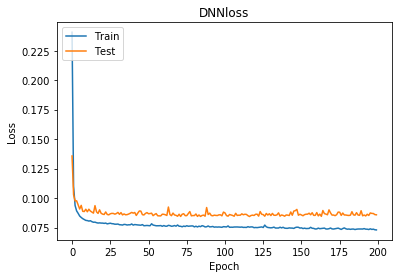

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DNNloss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CNN

In [25]:

model = Sequential()
model.add(Conv1D(32,5,input_shape=(train_X_c.shape[1],1), activation='relu',name='Conv1'))
# model.add(MaxPooling1D(8))
model.add(Conv1D(8, 3, activation='relu',name='Conv2'))
# model.add(MaxPooling1D(4))
# model.add(Conv1D(16,2, activation='relu'))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(MaxPooling1D(2))
model.add(Flatten(name='Flatten'))
model.add(Dense(units=128,activation='tanh',use_bias = True,name='Layer1'))
model.add(Dense(units=64,activation='tanh',use_bias = True,name='Layer2'))
model.add(Dense(units=32,activation='tanh',use_bias = True,name='Layer3'))
# model.add(Dense(units=8,name='layer4',activation='sigmoid',use_bias = True))
model.add(Dense(train_y.shape[1], activation='tanh',name='Output'))

plot_model(model,to_file="./picture/CNN_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
print(model.summary())

cnnstart = time.clock()   #开始时间计时
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
history = model.fit(train_X_c,train_y, validation_data=(eval_X_c, eval_y),epochs = 200, batch_size = 64,verbose=0)
cnnend = time.clock()

history_cnn = history
modelcnn = model
modelcnn.save('./H5/CNNall.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv1D)               (None, 48, 32)            192       
_________________________________________________________________
Conv2 (Conv1D)               (None, 46, 8)             776       
_________________________________________________________________
Flatten (Flatten)            (None, 368)               0         
_________________________________________________________________
Layer1 (Dense)               (None, 128)               47232     
_________________________________________________________________
Layer2 (Dense)               (None, 64)                8256      
_________________________________________________________________
Layer3 (Dense)               (None, 32)                2080      
_________________________________________________________________
Output (Dense)               (None, 52)                1716      
Total para

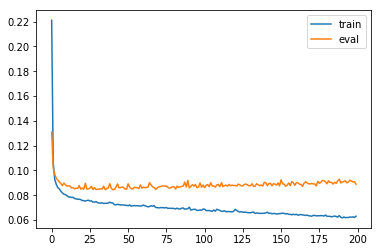

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM

In [176]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='LSTM1'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
print(model.summary())

lstmstart = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstmend = time.clock()

history_lstm = history
modellstm = model
modellstm.save('./H5/LSTMall.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 64)                29952     
_________________________________________________________________
Output (Dense)               (None, 52)                3380      
Total params: 33,332
Trainable params: 33,332
Non-trainable params: 0
_________________________________________________________________
None


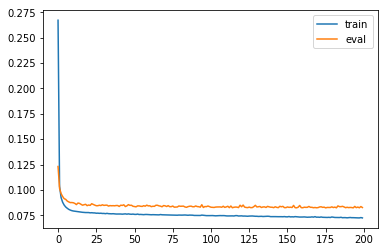

In [177]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# CNN-LSTM

In [31]:
model = Sequential()
model.add(LSTM(64, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True))

# model.add(Conv1D(16,8,input_shape=(train_X_c.shape[1],1), activation='relu'))
# model.add(MaxPooling1D(8))
# model.add(Conv1D(8, 4, activation='relu'))
# model.add(MaxPooling1D(4))
# model.add(Conv1D(16,2, activation='relu'))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Flatten())
# model.add(LSTM(64,activation='tanh',use_bias = True))
# model.add(Dense(units=256,activation='tanh',use_bias = True))
# model.add(Dense(units=128,activation='tanh',use_bias = True))
# model.add(Dense(units=64,activation='tanh',use_bias = True))
# model.add(Dense(units=8,name='layer4',activation='sigmoid',use_bias = True))
model.add(Dense(train_y.shape[1], activation='tanh'))


plot_model(model,to_file="./picture/CNN-LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
print(model.summary())

cnnlstmstart = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
cnnlstmend = time.clock()

history_cnnlstm = history
modelcnnlstm = model
modelcnnlstm.save('./H5/CNN-LSTMall.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                29952     
_________________________________________________________________
dense_1 (Dense)              (None, 52)                3380      
Total params: 33,332
Trainable params: 33,332
Non-trainable params: 0
_________________________________________________________________
None


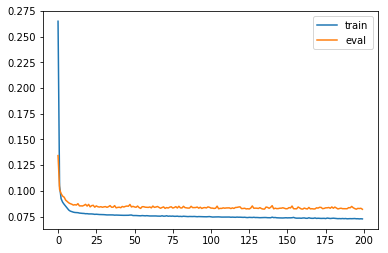

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# SimpleRNN

In [74]:
# design network
model = Sequential()
model.add(SimpleRNN(64, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='RNN1'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

plot_model(model,to_file="./picture/RNN_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
print(model.summary())

rnnstart = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=1)
rnnend = time.clock()

history_rnn = history
modelrnn = model
modelrnn.save('./H5/RNNall.h5')

# keras.layers.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN1 (SimpleRNN)             (None, 64)                7488      
_________________________________________________________________
Output (Dense)               (None, 52)                3380      
Total params: 10,868
Trainable params: 10,868
Non-trainable params: 0
_________________________________________________________________
None
Train on 2474 samples, validate on 1061 samples
Epoch 1/200
2474/2474 [==============================] - 1s - loss: 0.2521 - mean_absolute_error: 0.2521 - val_loss: 0.1333 - val_mean_absolute_error: 0.1333
Epoch 2/200
2474/2474 [==============================] - 0s - loss: 0.1116 - mean_absolute_error: 0.1116 - val_loss: 0.1066 - val_mean_absolute_error: 0.1066
Epoch 3/200
2474/2474 [==============================] - 0s - loss: 0.0968 - mean_absolute_error: 0.0968 - val_loss: 0.0989 - val_mean_absolute_error: 0.0989
Epoch 4

2474/2474 [==============================] - 0s - loss: 0.0771 - mean_absolute_error: 0.0771 - val_loss: 0.0864 - val_mean_absolute_error: 0.0864
Epoch 49/200
2474/2474 [==============================] - 0s - loss: 0.0771 - mean_absolute_error: 0.0771 - val_loss: 0.0864 - val_mean_absolute_error: 0.0864
Epoch 50/200
2474/2474 [==============================] - 0s - loss: 0.0772 - mean_absolute_error: 0.0772 - val_loss: 0.0854 - val_mean_absolute_error: 0.0854
Epoch 51/200
2474/2474 [==============================] - 0s - loss: 0.0771 - mean_absolute_error: 0.0771 - val_loss: 0.0858 - val_mean_absolute_error: 0.0858
Epoch 52/200
2474/2474 [==============================] - 0s - loss: 0.0773 - mean_absolute_error: 0.0773 - val_loss: 0.0866 - val_mean_absolute_error: 0.0866
Epoch 53/200
2474/2474 [==============================] - 0s - loss: 0.0771 - mean_absolute_error: 0.0771 - val_loss: 0.0851 - val_mean_absolute_error: 0.0851
Epoch 54/200
2474/2474 [==============================] - 0

2474/2474 [==============================] - 0s - loss: 0.0761 - mean_absolute_error: 0.0761 - val_loss: 0.0857 - val_mean_absolute_error: 0.0857
Epoch 100/200
2474/2474 [==============================] - 0s - loss: 0.0759 - mean_absolute_error: 0.0759 - val_loss: 0.0866 - val_mean_absolute_error: 0.0866
Epoch 101/200
2474/2474 [==============================] - 0s - loss: 0.0761 - mean_absolute_error: 0.0761 - val_loss: 0.0854 - val_mean_absolute_error: 0.0854
Epoch 102/200
2474/2474 [==============================] - 0s - loss: 0.0759 - mean_absolute_error: 0.0759 - val_loss: 0.0855 - val_mean_absolute_error: 0.0855
Epoch 103/200
2474/2474 [==============================] - 0s - loss: 0.0761 - mean_absolute_error: 0.0761 - val_loss: 0.0842 - val_mean_absolute_error: 0.0842
Epoch 104/200
2474/2474 [==============================] - 0s - loss: 0.0761 - mean_absolute_error: 0.0761 - val_loss: 0.0852 - val_mean_absolute_error: 0.0852
Epoch 105/200
2474/2474 [=============================

2474/2474 [==============================] - 0s - loss: 0.0758 - mean_absolute_error: 0.0758 - val_loss: 0.0849 - val_mean_absolute_error: 0.0849
Epoch 150/200
2474/2474 [==============================] - 0s - loss: 0.0759 - mean_absolute_error: 0.0759 - val_loss: 0.0851 - val_mean_absolute_error: 0.0851
Epoch 151/200
2474/2474 [==============================] - 0s - loss: 0.0756 - mean_absolute_error: 0.0756 - val_loss: 0.0843 - val_mean_absolute_error: 0.0843
Epoch 152/200
2474/2474 [==============================] - 0s - loss: 0.0756 - mean_absolute_error: 0.0756 - val_loss: 0.0863 - val_mean_absolute_error: 0.0863
Epoch 153/200
2474/2474 [==============================] - 0s - loss: 0.0756 - mean_absolute_error: 0.0756 - val_loss: 0.0863 - val_mean_absolute_error: 0.0863
Epoch 154/200
2474/2474 [==============================] - 0s - loss: 0.0756 - mean_absolute_error: 0.0756 - val_loss: 0.0851 - val_mean_absolute_error: 0.0851
Epoch 155/200
2474/2474 [=============================

2474/2474 [==============================] - 0s - loss: 0.0753 - mean_absolute_error: 0.0753 - val_loss: 0.0838 - val_mean_absolute_error: 0.0838
Epoch 200/200
2474/2474 [==============================] - 0s - loss: 0.0755 - mean_absolute_error: 0.0755 - val_loss: 0.0844 - val_mean_absolute_error: 0.0844


# GRU

In [143]:
# design network
model = Sequential()
model.add(GRU(64, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='GRU1'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

plot_model(model,to_file="./picture/GRU_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
print(model.summary())

grustart = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=1)
gruend = time.clock()

history_gru = history
modelgru = model
modelgru.save('./H5/GRUall.h5')


# keras.layers.GRU(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, reset_after=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU1 (GRU)                   (None, 64)                22464     
_________________________________________________________________
Output (Dense)               (None, 52)                3380      
Total params: 25,844
Trainable params: 25,844
Non-trainable params: 0
_________________________________________________________________
None
Train on 2474 samples, validate on 1061 samples
Epoch 1/200
2474/2474 [==============================] - 1s - loss: 0.2665 - mean_absolute_error: 0.2665 - val_loss: 0.1202 - val_mean_absolute_error: 0.1202
Epoch 2/200
2474/2474 [==============================] - 0s - loss: 0.1010 - mean_absolute_error: 0.1010 - val_loss: 0.0996 - val_mean_absolute_error: 0.0996
Epoch 3/200
2474/2474 [==============================] - 0s - loss: 0.0903 - mean_absolute_error: 0.0903 - val_loss: 0.0958 - val_mean_absolute_error: 0.0958
Epoch 4

2474/2474 [==============================] - 0s - loss: 0.0762 - mean_absolute_error: 0.0762 - val_loss: 0.0847 - val_mean_absolute_error: 0.0847
Epoch 49/200
2474/2474 [==============================] - 0s - loss: 0.0763 - mean_absolute_error: 0.0763 - val_loss: 0.0840 - val_mean_absolute_error: 0.0840
Epoch 50/200
2474/2474 [==============================] - 0s - loss: 0.0763 - mean_absolute_error: 0.0763 - val_loss: 0.0842 - val_mean_absolute_error: 0.0842
Epoch 51/200
2474/2474 [==============================] - 0s - loss: 0.0761 - mean_absolute_error: 0.0761 - val_loss: 0.0836 - val_mean_absolute_error: 0.0836
Epoch 52/200
2474/2474 [==============================] - 0s - loss: 0.0762 - mean_absolute_error: 0.0762 - val_loss: 0.0837 - val_mean_absolute_error: 0.0837
Epoch 53/200
2474/2474 [==============================] - 0s - loss: 0.0762 - mean_absolute_error: 0.0762 - val_loss: 0.0841 - val_mean_absolute_error: 0.0841
Epoch 54/200
2474/2474 [==============================] - 0

2474/2474 [==============================] - 0s - loss: 0.0750 - mean_absolute_error: 0.0750 - val_loss: 0.0839 - val_mean_absolute_error: 0.0839
Epoch 99/200
2474/2474 [==============================] - 0s - loss: 0.0751 - mean_absolute_error: 0.0751 - val_loss: 0.0826 - val_mean_absolute_error: 0.0826
Epoch 100/200
2474/2474 [==============================] - 0s - loss: 0.0753 - mean_absolute_error: 0.0753 - val_loss: 0.0827 - val_mean_absolute_error: 0.0827
Epoch 101/200
2474/2474 [==============================] - 0s - loss: 0.0753 - mean_absolute_error: 0.0753 - val_loss: 0.0850 - val_mean_absolute_error: 0.0850
Epoch 102/200
2474/2474 [==============================] - 0s - loss: 0.0749 - mean_absolute_error: 0.0749 - val_loss: 0.0834 - val_mean_absolute_error: 0.0834
Epoch 103/200
2474/2474 [==============================] - 0s - loss: 0.0753 - mean_absolute_error: 0.0753 - val_loss: 0.0830 - val_mean_absolute_error: 0.0830
Epoch 104/200
2474/2474 [==============================

2474/2474 [==============================] - 0s - loss: 0.0743 - mean_absolute_error: 0.0743 - val_loss: 0.0827 - val_mean_absolute_error: 0.0827
Epoch 150/200
2474/2474 [==============================] - 0s - loss: 0.0742 - mean_absolute_error: 0.0742 - val_loss: 0.0834 - val_mean_absolute_error: 0.0834
Epoch 151/200
2474/2474 [==============================] - 0s - loss: 0.0741 - mean_absolute_error: 0.0741 - val_loss: 0.0823 - val_mean_absolute_error: 0.0823
Epoch 152/200
2474/2474 [==============================] - 0s - loss: 0.0742 - mean_absolute_error: 0.0742 - val_loss: 0.0848 - val_mean_absolute_error: 0.0848
Epoch 153/200
2474/2474 [==============================] - 0s - loss: 0.0743 - mean_absolute_error: 0.0743 - val_loss: 0.0841 - val_mean_absolute_error: 0.0841
Epoch 154/200
2474/2474 [==============================] - 0s - loss: 0.0739 - mean_absolute_error: 0.0739 - val_loss: 0.0838 - val_mean_absolute_error: 0.0838
Epoch 155/200
2474/2474 [=============================

2474/2474 [==============================] - 0s - loss: 0.0731 - mean_absolute_error: 0.0731 - val_loss: 0.0830 - val_mean_absolute_error: 0.0830


In [36]:
# keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)

# 画出各个模型的网络结构并保存

In [37]:
# plot_model(model,to_file="./picture/DNN_model.svg",show_shapes=True)

# 输出各网络模型参数

# 预测验证集

In [178]:
##预测
dnn_pred = modeldnn.predict(eval_X)
cnn_pred = modelcnn.predict(eval_X_c)
lstm_pred = modellstm.predict(eval_X_l)

# cnnlstm_pred= modelcnnlstm.predict(eval_X_c)

cnnlstm_pred= modelcnnlstm.predict(eval_X_l)


In [179]:
rnn_pred = modelrnn.predict(eval_X_l)

In [180]:
gru_pred = modelgru.predict(eval_X_l)

In [181]:
# dnn_pred.shape
# print(dnn_pred)
# print(eval_y)
# print(cnn_pred)
# cnn_pred[0,:]

In [182]:
eval_y[31,:]

array([0.77103287, 0.76991695, 0.71664155, 0.8272143 , 0.8451417 ,
       0.87223905, 0.87473756, 0.84801847, 0.8320764 , 0.8239966 ,
       0.81397384, 0.87436354, 0.8859749 , 0.8336023 , 0.8733183 ,
       0.72233546, 0.76013434, 0.7842213 , 0.49255586, 0.8675188 ,
       0.76168424, 0.8341305 , 0.6424371 , 0.80513406, 0.73797   ,
       0.7218057 , 0.77886033, 0.7764755 , 0.7927215 , 0.7206791 ,
       0.7819987 , 0.74635285, 0.7128887 , 0.59010184, 0.67144847,
       0.66310304, 0.6136428 , 0.65966064, 0.61447406, 0.609689  ,
       0.3859685 , 0.44661313, 0.4453413 , 0.41739243, 0.3525962 ,
       0.1845254 , 0.12746866, 0.10149644, 0.05555983, 0.05338899,
       0.13144912, 0.09398612], dtype=float32)

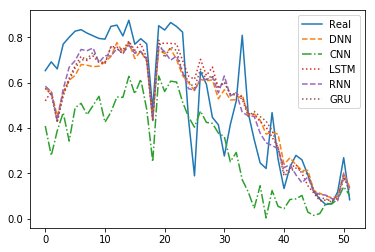

In [183]:
# fig = plt.figure(figsize=(9,6))
# ax=fig.add_subplot(1,1,1)

plt.plot(eval_y[19,:],label='Real',linestyle='-')
plt.plot(dnn_pred[19,:],label='DNN',linestyle='--')
plt.plot(cnn_pred[19,:],label='CNN',linestyle='-.')
plt.plot(lstm_pred[19,:],label='LSTM',linestyle=':')
# plt.plot(cnnlstm_pred[19,:],label='CNN-LSTM',linestyle='-.')

plt.plot(rnn_pred[19,:],label='RNN',linestyle='--')
plt.plot(gru_pred[19,:],label='GRU',linestyle=':')

plt.legend()

# plt.savefig('./picture/多模型归一化预测.jpg',dpi=300)
# plt.savefig('./picture/多模型归一化预测.svg',format="svg",dpi=300)

# 反归一化

In [184]:
print(' eval_X  cnn_pred eval_y.shape train1.shape\n',
      eval_X.shape,cnn_pred.shape,eval_y.shape, train1.shape)

 eval_X  cnn_pred eval_y.shape train1.shape
 (1061, 52) (1061, 52) (1061, 52) (3535, 104)


In [185]:
train_X.shape[1]

52

In [186]:
##定义反归一化函数
def inv(Predict,eval_X,eval_y,train_X,train_y):
#     X = np.squeeze(X)
    
    invpre_xy = concatenate((eval_X,Predict), axis=1)
    inveval_xy = concatenate((eval_X,eval_y),axis=1)
    invtrain_xy = concatenate((train_X,train_y),axis=1)
    
    # invert scaling for forecast
    invpredict = concatenate((invtrain_xy,invpre_xy),axis=0)
    invpredict = scaler.inverse_transform(invpredict)
    predict = invpredict[train_X.shape[0]:,train_X.shape[1]:]
    # invert scaling for actual
    invture = concatenate((invtrain_xy,inveval_xy),axis=0)
    invture = scaler.inverse_transform(invture)
    real = invture[train_X.shape[0]:,train_X.shape[1]:]
    return predict,real

In [187]:
##反归一化预测值

cnn_pred,y_true =inv(cnn_pred,eval_X,eval_y,train_X,train_y)
dnn_pred,y_true =inv(dnn_pred,eval_X,eval_y,train_X,train_y)
lstm_pred,y_true =inv(lstm_pred,eval_X,eval_y,train_X,train_y)
cnnlstm_pred,y_true = inv(cnnlstm_pred,eval_X,eval_y,train_X,train_y)

In [188]:
rnn_pred,y_true =inv(rnn_pred,eval_X,eval_y,train_X,train_y)

In [189]:
gru_pred,y_true =inv(gru_pred,eval_X,eval_y,train_X,train_y)

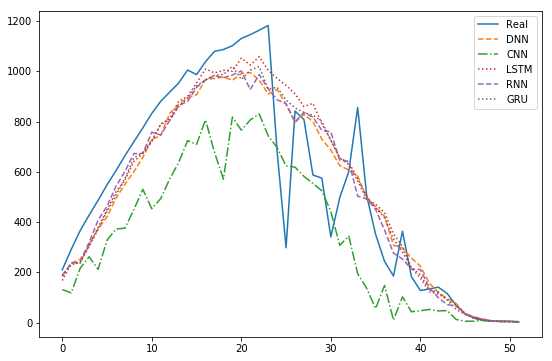

In [190]:
##反归一化预测值画图
fig = plt.figure(figsize=(9,6))
# ax=fig.add_subplot(1,1,1)
plt.plot(y_true[19,:],label='Real',linestyle='-')
plt.plot(dnn_pred[19,:],label='DNN',linestyle='--')
plt.plot(cnn_pred[19,:],label='CNN',linestyle='-.')
plt.plot(lstm_pred[19,:],label='LSTM',linestyle=':')
# plt.plot(cnnlstm_pred[19,:],label='CNN-LSTM',linestyle='-.')

plt.plot(rnn_pred[19,:],label='RNN',linestyle='--')
plt.plot(gru_pred[19,:],label='GRU',linestyle=':')

plt.legend()

# plt.savefig('./picture/多模型预测.jpg',dpi=300)
# plt.savefig('./picture/多模型预测.svg',format="svg",dpi=300)

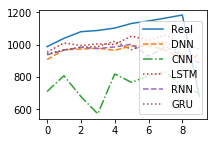

In [191]:
##反归一化预测值画图
fig = plt.figure(figsize=(3,2))
ax=fig.add_subplot(1,1,1)
plt.plot(y_true[19,15:25],label='Real',linestyle='-')
plt.plot(dnn_pred[19,15:25],label='DNN',linestyle='--')
plt.plot(cnn_pred[19,15:25],label='CNN',linestyle='-.')
plt.plot(lstm_pred[19,15:25],label='LSTM',linestyle=':')
# plt.plot(cnnlstm_pred[19,15:25],label='CNN-LSTM',linestyle='-.')

plt.plot(rnn_pred[19,15:25],label='RNN',linestyle='--')
plt.plot(gru_pred[19,15:25],label='GRU',linestyle=':')

plt.legend()

# plt.savefig('./picture/多模型预测细节.jpg',dpi=300)
# plt.savefig('./picture/多模型预测细节.svg',format="svg",dpi=300)

In [192]:
# y_true.shape
# dnn_pred.shape
# cnn_pred.shape

# 按指标计算预测精度

In [193]:
## MSE计算
dnn_mse = metrics.mean_squared_error(y_true, dnn_pred)
##RMSE计算
dnn_rmse = np.sqrt(mean_squared_error(y_true, dnn_pred))
##MAE计算
dnn_mae = metrics.mean_absolute_error(y_true, dnn_pred)

In [194]:
## MSE计算
cnn_mse = metrics.mean_squared_error(y_true, cnn_pred)
##RMSE计算
cnn_rmse = np.sqrt(mean_squared_error(y_true, cnn_pred))
##MAE计算
cnn_mae = metrics.mean_absolute_error(y_true, cnn_pred)

In [195]:
## MSE计算
lstm_mse = metrics.mean_squared_error(y_true, lstm_pred)
##RMSE计算
lstm_rmse = np.sqrt(mean_squared_error(y_true, lstm_pred))
##MAE计算
lstm_mae = metrics.mean_absolute_error(y_true, lstm_pred)

In [196]:
## MSE计算
cnnlstm_mse = metrics.mean_squared_error(y_true, cnnlstm_pred)
##RMSE计算
cnnlstm_rmse = np.sqrt(mean_squared_error(y_true, cnnlstm_pred))
##MAE计算
cnnlstm_mae = metrics.mean_absolute_error(y_true, cnnlstm_pred)

In [197]:
## MSE计算
rnn_mse = metrics.mean_squared_error(y_true, rnn_pred)
##RMSE计算
rnn_rmse = np.sqrt(mean_squared_error(y_true, rnn_pred))
##MAE计算
rnn_mae = metrics.mean_absolute_error(y_true, rnn_pred)

In [198]:
## MSE计算
gru_mse = metrics.mean_squared_error(y_true, gru_pred)
##RMSE计算
gru_rmse = np.sqrt(mean_squared_error(y_true, gru_pred))
##MAE计算
gru_mae = metrics.mean_absolute_error(y_true, gru_pred)

In [199]:
# ## MSE计算
# dnn_mse = metrics.mean_squared_error(y_true, dnn_pred)
# cnn_mse = metrics.mean_squared_error(y_true, cnn_pred)
# lstm_mse = metrics.mean_squared_error(y_true, lstm_pred)
# cnnlstm_mse = metrics.mean_squared_error(y_true,cnnlstm_pred)

# ##RMSE计算
# dnn_rmse = np.sqrt(mean_squared_error(y_true, dnn_pred))
# cnn_rmse = np.sqrt(mean_squared_error(y_true, cnn_pred))
# lstm_rmse = np.sqrt(mean_squared_error(y_true, lstm_pred))
# cnnlstm_rmse = np.sqrt(mean_squared_error(y_true,cnnlstm_pred)) 
# ##MAE计算
# dnn_mae = metrics.mean_absolute_error(y_true, dnn_pred)
# cnn_mae = metrics.mean_absolute_error(y_true, cnn_pred)
# lstm_mae = metrics.mean_absolute_error(y_true, lstm_pred)
# cnnlstm_mae = metrics.mean_absolute_error(y_true,cnnlstm_pred)

In [200]:
#生成表格
comparison = pd.DataFrame(columns=['Model','RunTime(s)','MSE','RMSE','MAE'])

In [201]:
comparison = comparison.append(pd.DataFrame({'Model':'DNN','RunTime(s)':[dnnend-dnnstart],'MSE':[dnn_mse],
                                             'RMSE':[dnn_rmse],'MAE':[dnn_mae]}),ignore_index=False,sort=False)

In [202]:
comparison = comparison.append(pd.DataFrame({'Model':'CNN','RunTime(s)':[cnnend-cnnstart],'MSE':[cnn_mse],
                                             'RMSE':[cnn_rmse],'MAE':[cnn_mae]}),ignore_index=False,sort=False)

In [203]:
comparison = comparison.append(pd.DataFrame({'Model':'LSTM','RunTime(s)':[lstmend-lstmstart],'MSE':[lstm_mse],
                                             'RMSE':[lstm_rmse],'MAE':[lstm_mae]}),ignore_index=False,sort=False)

In [204]:
comparison = comparison.append(pd.DataFrame({'Model':'CNN-LSTM','RunTime(s)':[cnnlstmend-cnnlstmstart],'MSE':[cnnlstm_mse],
                                             'RMSE':[cnnlstm_rmse],'MAE':[cnnlstm_mae]}),ignore_index=False,sort=False)

In [205]:
comparison = comparison.append(pd.DataFrame({'Model':'RNN','RunTime(s)':[rnnend-rnnstart],'MSE':[rnn_mse],
                                             'RMSE':[rnn_rmse],'MAE':[rnn_mae]}),ignore_index=False,sort=False)

In [206]:
comparison = comparison.append(pd.DataFrame({'Model':'GRU','RunTime(s)':[gruend-grustart],'MSE':[gru_mse],
                                             'RMSE':[gru_rmse],'MAE':[gru_mae]}),ignore_index=False,sort=False)

In [207]:
comparison

,Model,RunTime(s),MSE,RMSE,MAE
0,DNN,74.781002,24823.937500,157.556137,80.887764
0,CNN,110.423439,28463.923828,168.712555,83.738884
0,LSTM,106.512209,23646.980469,153.775742,78.022171
0,CNN-LSTM,107.123096,23763.966797,154.155655,77.416504
0,RNN,89.517704,23485.679688,153.250381,79.594963
0,GRU,124.681114,23278.789062,152.573883,78.431831


In [208]:
comparison.to_csv('./kpi/多模型比较结果%s.csv'%str(time.clock()).split('.')[0],index=False)

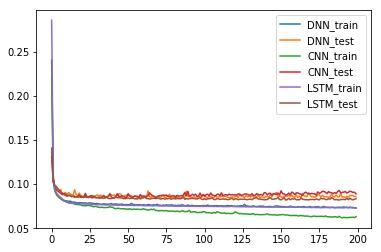

In [141]:
#各个损失

# plot history

plt.plot(history_dnn.history['loss'], label='DNN_train')
plt.plot(history_dnn.history['val_loss'], label='DNN_test')

plt.plot(history_cnn.history['loss'], label='CNN_train')
plt.plot(history_cnn.history['val_loss'], label='CNN_test')

plt.plot(history_lstm.history['loss'], label='LSTM_train')
plt.plot(history_lstm.history['val_loss'], label='LSTM_test')

plt.legend()
plt.show()